# **DESAFIO I**

# INSTALACIÓN E IMPORTACION DE LIBRERIAS

Todas las librerías que se utilizarán en el Trabajo Práctico se importan en esta sección.

Se optó por la utilización de Google Colab para el armado colaborativo del Trabajo Práctico por lo que se incluye el código que sigue para instalar la libreria de GeoPandas



In [ ]:
!pip install geopandas
!pip install pygeos
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
!pip install contextily

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import statistics as stat
import shapely.wkt
import matplotlib.pyplot as plt
import descartes
import seaborn as sns
import regex as re
import rtree
import pygeos
import contextily as ctx

# GLOSARIO

En esta sección definimos los nombres de los dataframes y geodataframes con los que vamos a trabajar

* data_raw: es el dataset original provisto por el curso

* geo_data_raw: es el dataset original provisto por el curso transformado en dataset espacial

* geo_data_final: es el dataset espacial final una vez realizada la limpieza y transformación de datos

# IMPORTACION Y EXPLORACIÓN DE DATASET

En este trabajo vamos a utilizar un dataset provisto por el curso en formato csv. Para poder trabajar de manera colaborativa lo hemos compartido en una carpeta de Drive y luego lo importamos como DataFrame de Pandas desde la ruta de ubicación del archivo.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
url = '/content/drive/MyDrive/DH - DESAFIO I/properati.csv'
data_raw = pd.read_csv(url)

## Consideraciones preliminares

En este apartado exploraremos el dataset con el que vamos a estar trabajando a fin de definir la estrategia de limpieza y transformación de datos, que desarrollaremos en el siguiente apartado. 

Como puede verse en las tablas que siguen, el mismo ha sido importado como un DataFrame de Pandas con **121.220 observaciones** (filas) que registran datos de inmuebles organizados en **26 variables** (columnas).

Lo primero que salta a la vista es la cantidad de datos faltantes que registran algunas de estas variables. Puede también observarse que los existentes no se encuentran estandarizados según el tipo que deberían asumir de acuedo a la clase de variables a la que refieren (categóricas, continuas, discretas). Asimismo encontramos que existen múltiples variables que dan cuenta del precio y la localización de los inmuebles, pudiendo inferirse de ello que podrían existir incongruencias entre las mismas.
Al imprimir una muestra del dataset podemos advertir que la primera columna no aporta ninguna información adicional sino que repite los números de indexación. 


In [5]:
display(data_raw.shape)
display(data_raw.info())

(121220, 26)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

None

In [6]:
data_raw.sample(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
32197,32197,sell,apartment,Capital Federal,|Argentina|Capital Federal|,Argentina,Capital Federal,3433955.0,NaN,NaN,...,75.0,NaN,3666.666667,3.0,NaN,NaN,http://www.properati.com.ar/186cl_venta_depart...,3 Ambientes.Cocheras Dobles Fijas para cada Un...,"Departamento con Plantas, Argentina, Capital F...",https://thumbs4.properati.com/1/rJHogFefS1UD3Q...
91684,91684,sell,apartment,Córdoba,|Argentina|Córdoba|,Argentina,Córdoba,3860255.0,NaN,NaN,...,50.0,2400.000000,2400.000000,NaN,NaN,1000.0,http://www.properati.com.ar/1bbwc_venta_depart...,DEPARTAMENTO CON ESCRITURADos dormitorios + es...,VENTA/ Nueva Cordoba 2 Dormitorios - San Loren...,https://thumbs4.properati.com/3/ArIuuSPgiTxbvH...
41303,41303,sell,apartment,Villa General Belgrano,|Argentina|Córdoba|Villa General Belgrano|,Argentina,Córdoba,3832734.0,"-31.970766,-64.553148",-31.970766,...,5100.0,NaN,33.333333,NaN,5.0,NaN,http://www.properati.com.ar/18txw_venta_depart...,Corredor Responsable: Matiaz Ruiz Moreno - CPC...,DÚPLEX FINANCIO 5-10 AÑOS VILLA GENERAL BELGRANO,https://thumbs4.properati.com/0/SEG3YXONubVFcp...
120309,120309,sell,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863.0,NaN,NaN,...,95.0,1486.217400,27894.736842,NaN,NaN,NaN,http://www.properati.com.ar/1chrk_venta_depart...,CATAMARCA 1239De estilo moderno y con diseño d...,4 AMBIENTES AL COSTO EN POZO ZONA LA PERLA INV...,https://thumbs4.properati.com/5/4cwKAGqu16qjVY...
85165,85165,sell,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Argentina,Capital Federal,3428113.0,NaN,NaN,...,79.0,2168.839884,42098.088608,NaN,NaN,NaN,http://www.properati.com.ar/1b2oc_venta_depart...,EXCELENTE TRES AMBIENTES A ESTRENAR!! UBICADO ...,3 Ambientes en San Telmo a estrenar APTO PROFE...,https://thumbs4.properati.com/6/exygxcEgN1NqEv...



En virtud de estas consideraciones preliminares, nuestro proceso de *data wrangling* deberá contemplar:  
*   la imputación de datos en los campos faltantes para nuestras variables de interés cuando ésto sea posible
*   la corrección o reimputación de datos en los campos en que se encuentren incongruencias
*   la estandarización de los tipos de datos para facilitar su análisis, visualización y posterior modelización

Pero antes de comenzar con el proceso de limpieza y transformación de datos en la sección siguiente, analicemos la distribución de las variables del dataset y de los campos vacíos. 

## Distribución de las variables de interés

###Variables cuantitativas o intervalares

En la tabla que sigue podemos observar las principales métricas que dan cuenta de la distribución de nuestras ***variables cuantitativas*** de interés. En ella se contabiliza el número de registros con datos para cada una de éstas y se presentan algunas medidas de dispersión (desvío estandar, mínimo y máximo valor asumido) y de tendencia central (promedio, mediana central -percentil 50- y medianas de las observaciones ubicadas a su izquierda -percentil 25- y a su derecha -percentil 75). Como puede verse, la distribución de estas variables evidencia una gran dispersión de datos, con valores mínimos y máximos muy alejados de la media y la mediana: 

In [7]:
variables_cuanti = data_raw.loc[:, ('price_aprox_usd', 'surface_total_in_m2', 'rooms', 'price_usd_per_m2')]
variables_cuanti.describe().round()

,price_aprox_usd,surface_total_in_m2,rooms,price_usd_per_m2
count,100810.0,81892.0,47390.0,68617.0
mean,239701.0,234.0,3.0,2160.0
std,391324.0,1782.0,2.0,2759.0
min,0.0,0.0,1.0,1.0
25%,89734.0,50.0,2.0,1218.0
50%,145000.0,84.0,3.0,1800.0
75%,265000.0,200.0,4.0,2486.0
max,46545445.0,200000.0,32.0,206333.0


En los graficos que siguen podemos visualizar esta dispersión de un modo aún más claro para las primeras dos variables de la tabla.

Como se puede ver, varias de las observaciones de nuestro set de datos registran **valores atípicos *(outliers)*** desde el punto de vista de su distribución. Es decir, se ubican por fuera del rango determinado, en su límite inferior, por el primer cuartil menos el 1,5 del rango intercuartil (Q1-1,5.IQR) y por el tercer cuartil más el 1,5 del rango intercuartil (Q3+1,5.IQR) en su límite superior. O dicho de un modo más simple, se encuentran por fuera del rango delimitado por los los bordes inferior y superior de la caja del BoxPlot. 

También puede observarse la presencia de **valores atípicos extremos**, es decir aquellos que se encuentran por fuera del rango comprendido entre Q1-3.IQR y Q3+3.IQR, delimitado por las líneas paralelas a la caja.

* Comencemos por visualizar la dispersión de los valores que asume la variable ***precios*** para los diferentes tipos de propiedad y según la provincia o región donde éstas se ubican: como puede verse, la dispersión en la distribución de los precios varía de acuerdo al tipo de inmueble que estamos mirando y su localización. 

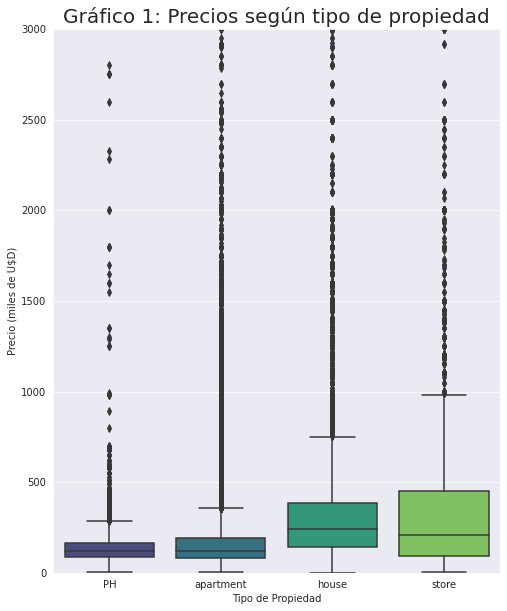

In [8]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(8, 10))
ax = plt.axes()
sns.boxplot(data=data_raw, y=data_raw['price_aprox_usd']/1000, x='property_type', palette='viridis')
ax.set_ylim(0, 3000)

plt.ylabel('Precio (miles de U$D)');
plt.xlabel('Tipo de Propiedad')
plt.title('Gráfico 1: Precios según tipo de propiedad', size=20)

plt.show()

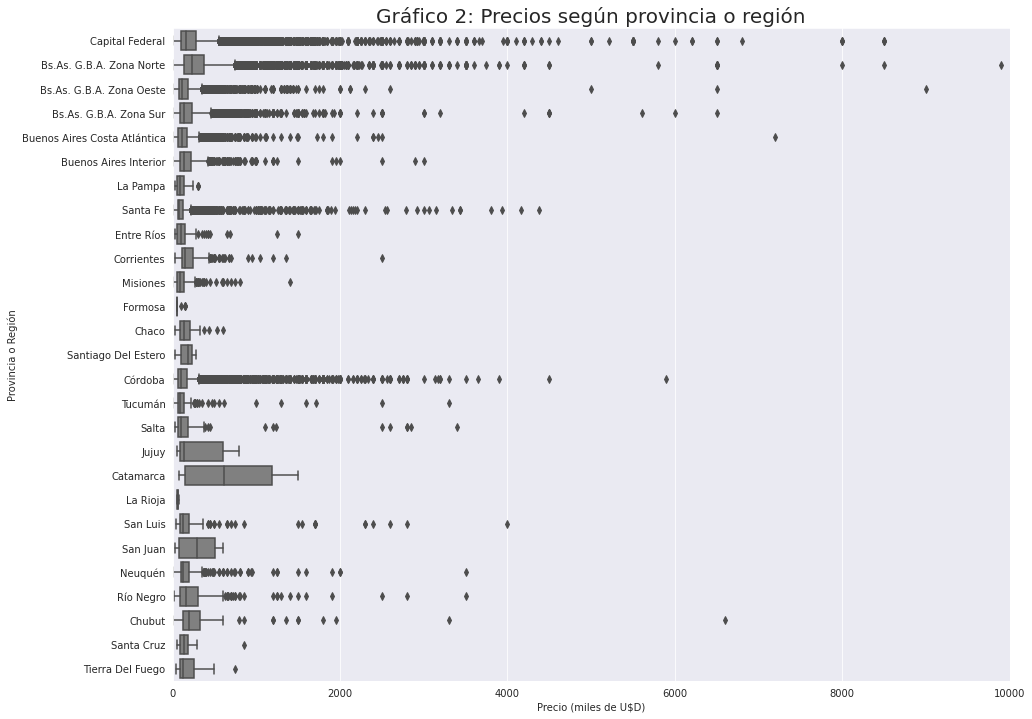

In [9]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15, 12))
ax = plt.axes()
sns.boxplot(data=data_raw, y='state_name', x=data_raw['price_aprox_usd']/1000, color='gray',
          order=['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 
         'Buenos Aires Costa Atlántica','Buenos Aires Interior', 'La Pampa', 'Santa Fe','Entre Ríos', 'Corrientes', 'Misiones', 
         'Formosa','Chaco','Santiago Del Estero', 'Córdoba', 'Tucumán', 'Salta','Jujuy','Catamarca','La Rioja', 'San Luis','San Juan', 
         'Neuquén','Río Negro','Chubut', 'Santa Cruz', 'Tierra Del Fuego'])

ax.set_xlim(0, 10000)

plt.xlabel('Precio (miles de U$D)');
plt.ylabel('Provincia o Región')
plt.title('Gráfico 2: Precios según provincia o región', size=20)

plt.show()

* También en la ***superficie*** puede observarse una gran dispersión. Los gráficos que se presentan a continuación muestran la distribución de los valores que asume esta variable para los inmuebles, según el tipo de propiedad y su ubicación.

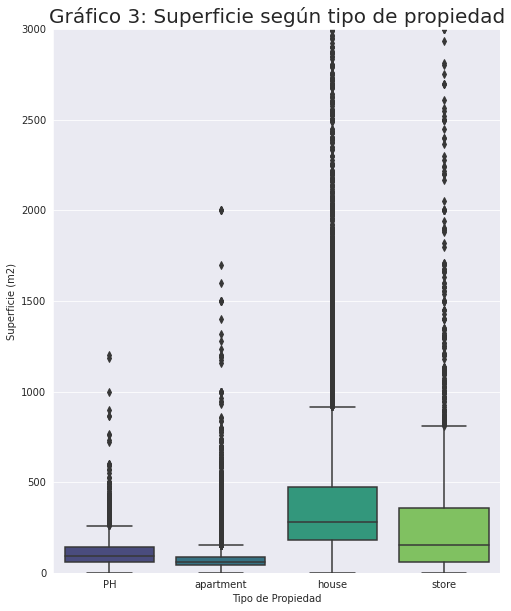

In [10]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(8, 10))
ax = plt.axes()
sns.boxplot(data=data_raw, y='surface_total_in_m2', x='property_type', palette='viridis')

ax.set_ylim(0, 3000)

plt.ylabel('Superficie (m2)');
plt.xlabel('Tipo de Propiedad')
plt.title('Gráfico 3: Superficie según tipo de propiedad', size=20)

plt.show()

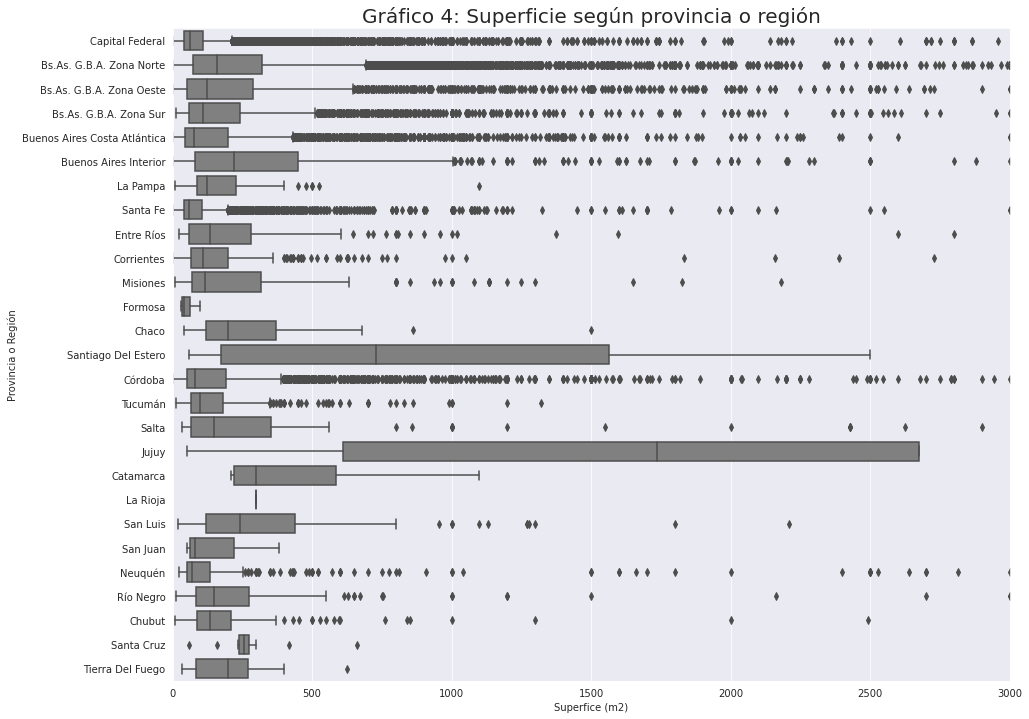

In [11]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15, 12))
ax = plt.axes()
sns.boxplot(data=data_raw, y='state_name', x='surface_total_in_m2', color='gray',
          order=['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 
         'Buenos Aires Costa Atlántica','Buenos Aires Interior', 'La Pampa', 'Santa Fe','Entre Ríos', 'Corrientes', 'Misiones', 
         'Formosa','Chaco','Santiago Del Estero', 'Córdoba', 'Tucumán', 'Salta','Jujuy','Catamarca','La Rioja', 'San Luis','San Juan', 
         'Neuquén','Río Negro','Chubut', 'Santa Cruz', 'Tierra Del Fuego'])

ax.set_xlim(0, 3000)

plt.xlabel('Superfice (m2)');
plt.ylabel('Provincia o Región')
plt.title('Gráfico 4: Superficie según provincia o región', size=20)

plt.show()

Como evidencian los histogramas que siguen, la distribución de frecuencia tanto de los precios como de la superficie tiene una forma **asimétrica sesgada a la derecha**. Es decir que los valores atípicos más extremos se encuentran en la cola derecha de la curva de distribución. Por este motivo, como puede verificarse en las tablas que se presentan más abajo, la moda y la mediana se ubican a la izquierda de la media:

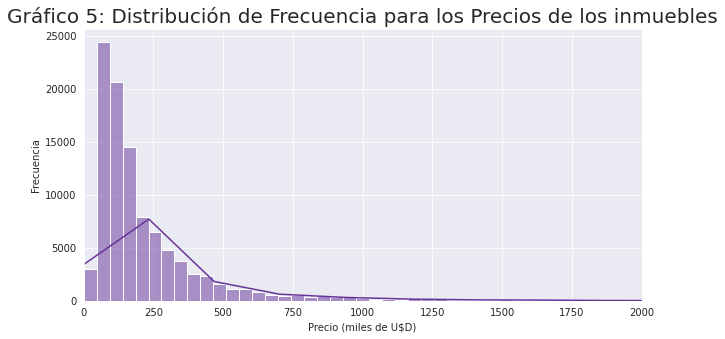

In [12]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_xlim(0, 2000)

sns.histplot(data=data_raw, x=data_raw['price_aprox_usd']/1000, color='rebeccapurple', bins=1000, kde=True)

plt.xlabel('Precio (miles de U$D)');
plt.ylabel('Frecuencia')
plt.title('Gráfico 5: Distribución de Frecuencia para los Precios de los inmuebles', size=20)

plt.show()

In [13]:
precioxtipo = data_raw.groupby('property_type').price_aprox_usd
precioxtipo.aggregate([np.min, stat.mode, np.median, np.mean, np.max]).round(2)

,amin,mode,median,mean,amax
property_type,,,,,
PH,5047.53,120000.0,120000.0,147689.42,2800000.0
apartment,4666.62,85000.0,119000.0,187406.88,46545445.0
house,0.00,250000.0,240000.0,329696.78,25000000.0
store,4952.45,250000.0,210000.0,440257.06,13000000.0


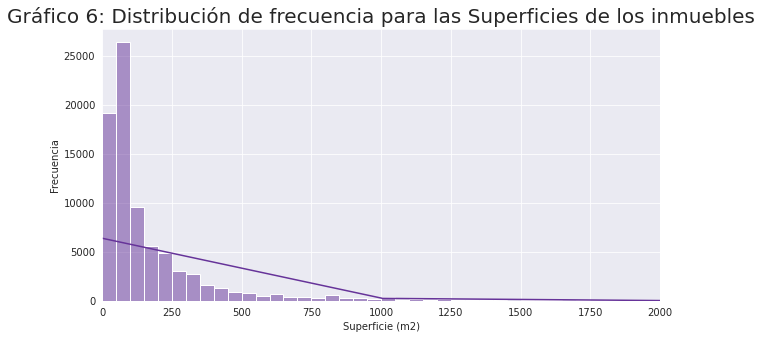

In [14]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_xlim(0, 2000)

sns.histplot(data=data_raw, x='surface_total_in_m2',  color='rebeccapurple', bins=4000, kde=True)

plt.xlabel('Superficie (m2)');
plt.ylabel('Frecuencia')
plt.title('Gráfico 6: Distribución de frecuencia para las Superficies de los inmuebles', size=20)

plt.show()

In [15]:
supxtipo = data_raw.groupby('property_type').surface_total_in_m2
supxtipo.aggregate([np.min, np.median, np.mean, np.max]).round(2)
#no se muestra la moda porque no es unimodal

,amin,median,mean,amax
property_type,,,,
PH,0.0,90.0,122.30,14742.0
apartment,0.0,59.0,96.61,200000.0
house,0.0,278.0,507.44,154438.0
store,0.0,154.0,494.51,93000.0


La existencia de valores atípicos tan extremos (cercanos a 0 en la punta inferior o izquierda según el gráfico, y que multiplican hasta más que por mil a las medidas de tendencia central en la punta superior o derecha) podría estar dando cuenta de errores o diferencia de criterio en la carga, problema que abordaremos más adelante.

In [16]:
precioxtipo = (data_raw.loc[:,('property_type','price_aprox_usd','surface_total_in_m2','rooms')]).groupby('property_type')
precioxtipo.aggregate([min, np.mean, max]).round(2)

price_aprox_usd                        surface_total_in_m2  \
                          min       mean         max                 min   
property_type                                                              
PH                    5047.53  147689.42   2800000.0                 0.0   
apartment             4666.62  187406.88  46545445.0                 0.0   
house                    0.00  329696.78  25000000.0                 0.0   
store                 4952.45  440257.06  13000000.0                 0.0   

                                rooms              
                 mean       max   min  mean   max  
property_type                                      
PH             122.30   14742.0   1.0  3.22  20.0  
apartment       96.61  200000.0   1.0  2.51  32.0  
house          507.44  154438.0   1.0  4.45  32.0  
store          494.51   93000.0   1.0  2.44  10.0

Como puede verse en los boxplot que realizamos, la dispersión en la distribución del precio y la superficie varía según el tipo de propiedad y la provincia o región del país donde se encuentre. Puede verse que el promedio más bajo corresponde a los PH y el más alto a los locales y que los precios máximos más extremos se concentran en los departamentos. En relación a la ubicación de las propiedades, puede observarse que los mayores precios se registran en capital federal y las provincias de buenos aires, santa fé y córdoba, que como veremos son además las que concentran la mayor cantidad de observaciones. En cuanto a las superficies podemos ver que los departamentos registran el promedio más pequeño, seguidos por los PH, mientras que las casas y los locales presentan las superficies en promedio más grandes y también los registros máximos más extremos. También puede verse que el promedio y dispersión de las superficies varía considerablemente según la localización de las propiedades.

### Variables cualitativas o categóricas

* En cuanto al ***tipo de operación***, podemos ver que todas las observaciones del dataset corresponden a ventas. Mientras que para los ***tipos de propiedad*** encontramos cuatro categorías posibles, de las cuales la de departamentos concentra el mayor número de observaciones en el dataset, acumulando, como se observa en la tabla y el gráfico que se presentan más abajo, más de la mitad de los registros. Del resto de las observaciones, más de un tercio corresponden a la categoría de casas; casi el 5% a PHs y algo más del 3% a locales. 

In [17]:
display(data_raw.operation.unique())
display(data_raw.operation.describe())
display(data_raw.property_type.unique())
display(data_raw.property_type.describe())

array(['sell'], dtype=object)

count     121220
unique         1
top         sell
freq      121220
Name: operation, dtype: object

array(['PH', 'apartment', 'house', 'store'], dtype=object)

count        121220
unique            4
top       apartment
freq          71065
Name: property_type, dtype: object

In [18]:
inmuebles_sg_tipo = pd.DataFrame({'cantidad':data_raw.groupby('property_type')['operation'].count()})
inmuebles_sg_tipo['%']=(data_raw.groupby('property_type')['operation'].count()/data_raw.shape[0]*100).round(2)
inmuebles_sg_tipo.sort_values(by='cantidad', ascending=False)


,cantidad,%
property_type,,
apartment,71065,58.62
house,40268,33.22
PH,5751,4.74
store,4136,3.41


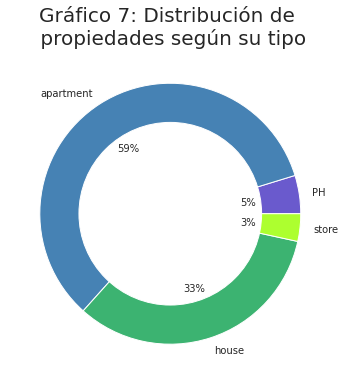

In [19]:
fig = plt.figure(figsize=(6, 6))
labels = inmuebles_sg_tipo.index
plt.pie(x=inmuebles_sg_tipo['%'], labels=labels, autopct='%.0f%%', colors=['slateblue','steelblue','mediumseagreen', 'greenyellow'])
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Gráfico 7: Distribución de \n propiedades según su tipo', size=20)
plt.show()

* Respecto de la ***localización*** de las propiedades, podemos ver que las mismas se concentran en la Provincia de Buenos Aires, que acumula un 50.43 % de las observaciones si se consideran todas las regiones que la componen (zona norte, zona sur, zona oeste, costa atlántica e interior), la ciudad de Buenos Aires, con un 26.66 %, y las provincias de Córdoba y Santa Fe, que registran -respectivamente- el 9.96 y el 8.39 % de las observaciones. Por su parte, el resto del país reúne apenas un 4,56% de los registros.

In [20]:
ubi_propiedades = pd.DataFrame({'%':(data_raw.groupby('state_name')['operation'].count()
                                 /data_raw.shape[0]*100).round(2)}).sort_values(by='%', ascending=False)
resumen_ubi=ubi_propiedades.loc['Capital Federal':'Buenos Aires Interior',:]
resto_pais=pd.Series(data=ubi_propiedades.loc['Río Negro':,:].sum(), name='Resto del País')
resumen_ubi=resumen_ubi.append(resto_pais, ignore_index=False).sort_values(by='%', ascending=False)
resumen_ubi

,%
state_name,
Capital Federal,26.66
Bs.As. G.B.A. Zona Norte,21.09
Bs.As. G.B.A. Zona Sur,11.51
Córdoba,9.96
Santa Fe,8.39
Buenos Aires Costa Atlántica,8.25
Bs.As. G.B.A. Zona Oeste,7.69
Resto del País,4.55
Buenos Aires Interior,1.89


Text(0.5, 0, '% de Propiedades')

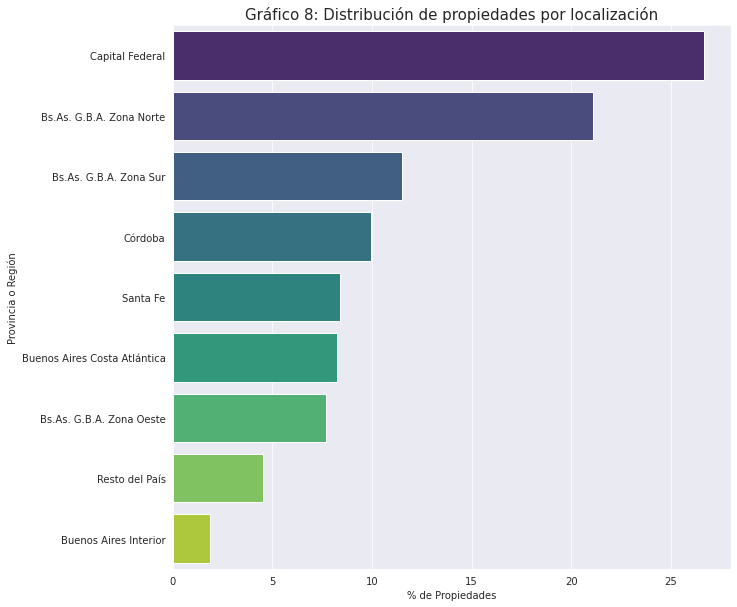

In [21]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

sns.barplot(x = resumen_ubi['%'], y=resumen_ubi.index, palette = 'viridis')

plt.title('Gráfico 8: Distribución de propiedades por localización', size=15)
plt.ylabel("Provincia o Región")
plt.xlabel("% de Propiedades")



## Datos Faltantes (*missing*)

Cómo puede verse en el gráfico que presentamos a continuación, nnuestra base tiene un 22% de campos sin datos:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


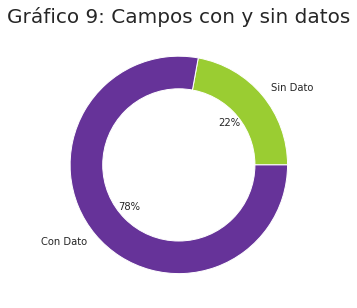

In [22]:
missing= pd.DataFrame({'cantidad':data_raw.isnull().sum()})
missing['%_faltantes']=(missing.cantidad/missing.cantidad.sum()*100).round(2)
missing['%_variable']=(missing.cantidad/data_raw.shape[0]*100).round(2)
missing_totales= pd.DataFrame({'%_sin_dato':[(missing.cantidad.sum()/(data_raw.shape[0]*data_raw.shape[1])*100).round(2)], 
                               '%_con_dato':[((data_raw.shape[0]*data_raw.shape[1]-missing.cantidad.sum())/
                                            (data_raw.shape[0]*data_raw.shape[1])*100).round(2)]})


fig = plt.figure(figsize=(5, 5))
labels = ['Sin Dato','Con Dato']
plt.pie(x=missing_totales, labels=labels, autopct='%.0f%%', colors=['yellowgreen','rebeccapurple'])
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Gráfico 9: Campos con y sin datos', size=20)
plt.show()

En la tabla  y el gráfico que siguen podemos observar cómo se distribuyen estos datos faltantes en relación, por un lado, a la totalidad de los datos faltantes (%_faltantes) y, por otro, a la cantidad de observaciones con y sin dato para la variable (%_variable):
* La mayor parte de éstos se concentra en los campos correspondientes a las variables de número de piso, monto de expensas y cantidad de ambientes, que explican casi el 40% de los missing totales. 
* Si bien la localización de los inmuebles se encuentra completa en cuanto a la localidad, provincia y país, el dataset no cuenta con datos completos en relación a la georreferenciación de su ubicación. 
* En cuanto a los precios, la mayor proporción de datos faltantes corresponde a los precios por metro cuadrado, presumiblemente por la falta de datos en al menos alguna de las variables a partir de las cuales se calcula (precio / superficie). 
* El resto de las variables relativas al precio de los inmuebles tienen la misma proporción de datos faltantes que la variable que indica la moneda, dando cuenta de que las expresiones de los precios en moneda local y en dólares están calculadas a partir de ésta.

In [23]:
missing.sort_values(by='cantidad', ascending=False)

,cantidad,%_faltantes,%_variable
floor,113321,16.24,93.48
expenses,106958,15.33,88.23
rooms,73830,10.58,60.91
price_usd_per_m2,52603,7.54,43.39
lat-lon,51550,7.39,42.53
lat,51550,7.39,42.53
lon,51550,7.39,42.53
surface_total_in_m2,39328,5.64,32.44
price_per_m2,33562,4.81,27.69
currency,20411,2.93,16.84


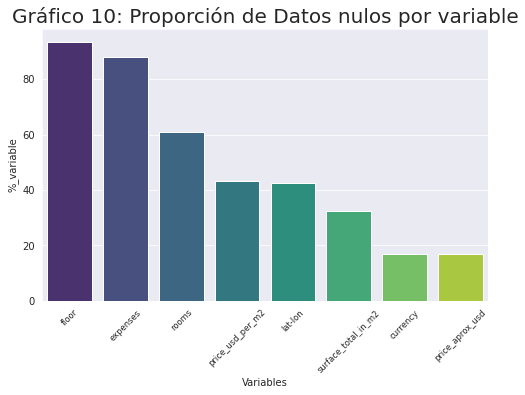

In [24]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(8, 5))
ax = plt.axes()
plt.title('Gráfico 10: Proporción de Datos nulos por variable', size=20)
plt.ylabel("Missing Data (%)")
plt.xlabel("Variables")
ax.set_xticklabels(missing.index, rotation = 45, fontsize='small')
sns.barplot(x = missing.index, y= missing['%_variable'], palette = 'viridis', order = 
            ['floor', 'expenses', 'rooms', 'price_usd_per_m2', 'lat-lon', 'surface_total_in_m2', 'currency', 'price_aprox_usd'])

Si nos detenemos sobre la variable a explicar (el precio) podemos ver que registra un 16.84 % de campos sin datos, lo cual explica un 2.93% de los datos faltantes. Sin embargo, como puede apreciarse a continuación, si miramos cómo se encuentra distribuida esta falta de datos entre los diferentes tipos de propiedad, podemos advertir que en la categoría que registra la mayor cantidad de observaciones (departamentos) el nivel de missing es un poco menor que para la base en su conjunto, cayendo a un 9% de datos faltantes. 

Cantidad total de elementos nulos para los precios en U$D: 11449 nulos filtrados por departamento
Porcentaje total de elementos nulos para los precios en U$D: 9% nulos filtrados por departamento


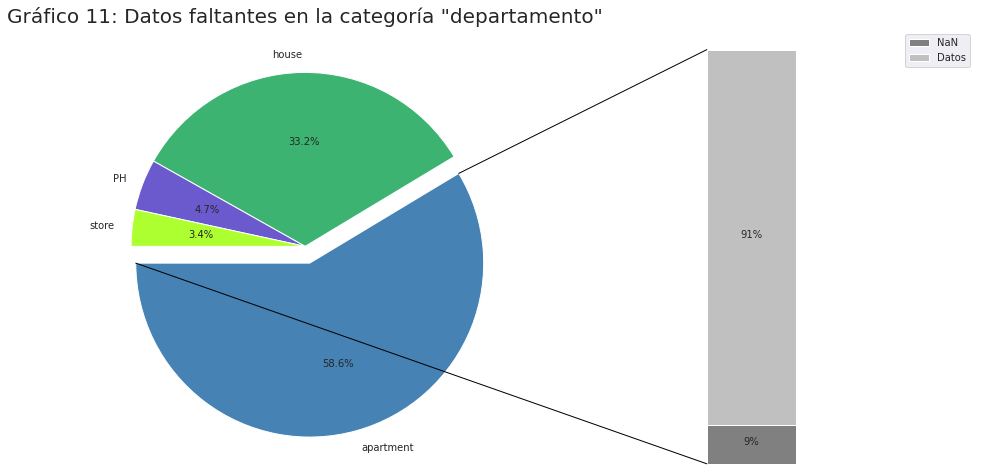

In [25]:
data_filtrada = data_raw["price_aprox_usd"][data_raw["property_type"]=='apartment']
data_filtrada_sum = data_raw["price_aprox_usd"][data_raw["property_type"]=='apartment'].isnull().sum()
print(f'Cantidad total de elementos nulos para los precios en U$D: {data_filtrada_sum} nulos filtrados por departamento')
Porcentajes_nulos_Apartment = data_raw["price_aprox_usd"][data_raw["property_type"]=='apartment'].isnull().sum()/data_raw["price_aprox_usd"].shape[0]
print(f'Porcentaje total de elementos nulos para los precios en U$D: {round(Porcentajes_nulos_Apartment*100)}% nulos filtrados por departamento')

TotalesX = data_raw["property_type"].value_counts()
datosX = np.array(TotalesX)
datosY = np.array([Porcentajes_nulos_Apartment, 0.91])
from matplotlib.patches import ConnectionPatch
# make figure and assign axis objects
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)


# pie chart parameters
ratios = datosX
labels = ['apartment', 'house', 'PH','store']
explode = [0.1, 0, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode, colors=['steelblue','mediumseagreen', 'slateblue', 'greenyellow'])
ax1.set_title('Gráfico 11: Datos faltantes en la categoría "departamento"', size=20)

# bar chart parameters

xpos = 0
bottom = 0
ratios = datosY
width = .2
colors= ['grey','silver']

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.legend(('NaN','Datos'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, bar_height), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, 0), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()

El análisis exploratorio realizado nos permitió establecer algunos objetivos y trazar los alcances que debería tener el proceso de limpieza y transformación de datos. Pero también puso en evidencia la necesidad de tomar algunas decisiones.
Una primera decisión que tomamos, en este sentido fue no eliminar ni variables ni observaciones de la base, aún cuando no contengan información relevante, ya que estas operaciones son muy sencillas en términos del código que implican y podemos realizarlas en cualquier momento. Por el mismo motivo decidimos no eliminar en esta etapa outliers de la base. En cambio, decidimos centrar el proceso de data wrangling en la imputación de datos para los campos faltantes o su reimputación en los casos en que identificamos incongruencias.

# LIMPIEZA Y TRANSFORMACIÓN DE DATOS

En esta sección imputaremos datos en los campos faltantes o en aquellos que hemos encontrado inconsistencias, reponiéndolos o reconstruyéndolos a partir de la información disponible en otras variables correspondientes a la misma observación.

Dado que el objetivo ulterior del trabajo será generar un modelo predictivo de tasación, no realizaremos imputaciones de datos que no podamos reponer o reconstruir ni para la variable a explicar (precio) ni para las variables que presumimos explicativas (ubicación, superficie, cantidad de ambientes, etc.) a fin de no sesgar el modelo con nuestros propios supuestos.

## Cantidad de ambientes

Para completar los datos faltantes de cantidad ambientes, buscamos coincidencias en las variables de título y descripción. Cabe aclarar que se encontró en estos campos, tanto información relativa a la cantidad de ambientes como de dormitorios, y asimismo diferentes criterios de carga (monoambiente vs 1 ambiente) debiendo realizar algunas operaciones adicionales para poder contar con una columna unificada. 

In [26]:
#Definicion funcion y patron para busqueda de ambientes
data_ambientes = data_raw.loc [:, ('title','description')]

amb_pattern = re.compile("(?P<cantidad>\d+)\s(?P<ambientes>amb|ambientes|ambiente)", flags = re.IGNORECASE )

amb_title_search = data_ambientes.title.apply(lambda x : x if x is np.NaN else amb_pattern.search(x))
ambtitle_notnull = amb_title_search.notnull()
amb_title = amb_title_search[ambtitle_notnull].apply(lambda x: x if x is None else x.group(1)).astype('int64')
#Elimino datos "sospechosos"
out_mask_title = amb_title < 11
data_ambientes['Ambientes'] = amb_title[out_mask_title]

amb_descr_search = data_ambientes.description.apply(lambda x:  x if x is np.NaN else amb_pattern.search(x))
ambdescr_notnull = amb_descr_search.notnull()
amb_descr = amb_descr_search[ambdescr_notnull].apply(lambda x: x if (x is np.NaN)|(x is None) else x.group(1)).astype('int64')
#Elimito datos "sospechosos" y ceros
out_mask_descr = (amb_descr != 0) & (amb_descr < 11)
amb_descr = amb_descr[out_mask_descr]
data_ambientes.Ambientes.fillna(amb_descr, inplace = True)

In [27]:
#Definicion patron para busqueda de dormitorios
dorm_pattern = re.compile("(?P<cantidad>\d+)\s(?P<dormitorios>dorm|dormitorio|dormitorios)", flags = re.IGNORECASE )

dorm_title_search = data_ambientes.title.apply(lambda x : x if x is np.NaN else dorm_pattern.search(x))
dormtitle_notnull = dorm_title_search.notnull()
data_ambientes['Dormitorios'] = dorm_title_search[dormtitle_notnull].apply(lambda x: x if x is None else x.group(1)).astype('int64')

dorm_descr_search = data_ambientes.description.apply(lambda x : x if x is np.NaN else dorm_pattern.search(x))
dormdescr_notnull = dorm_descr_search.notnull()
dorm_descr = dorm_descr_search[dormdescr_notnull].apply(lambda x: x if x is None else x.group(1)).astype('int64')
#Elimito datos "sospechosos" y ceros
out_mask_descr_2 = (dorm_descr != 0) & (dorm_descr < 11)
dorm_desc = dorm_descr[out_mask_descr_2]
data_ambientes.Dormitorios.fillna(dorm_desc, inplace = True)

dorm = data_ambientes.Dormitorios + 1 
data_ambientes.Ambientes.fillna(dorm, inplace = True)

In [28]:
#Definicion patron de busqueda monoambientes
mono_pattern = re.compile("monoambiente", flags = re.IGNORECASE )

mono_title_search = data_ambientes.title.apply(lambda x : x if x is np.NaN else mono_pattern.search(x))
monotitle_notnull = mono_title_search.notnull()
mono_title = mono_title_search[monotitle_notnull].apply(lambda x: x if x is None else x.group()).str.lower()
mask_1 = mono_title.notnull() == 1
data_ambientes['Monoambiente'] = mono_title[mask_1].apply(lambda x: x if x is False else 1)

mono_descr_search = data_ambientes.description.apply(lambda x : x if x is np.NaN else mono_pattern.search(x))
monodescr_notnull = mono_descr_search.notnull()
mono_descr = mono_descr_search[monodescr_notnull].apply(lambda x: x if x is None else x.group()).str.lower()
mask_2 = mono_descr.notnull() == 1
mono_num = mono_descr[mask_2].apply(lambda x: x if x is False else 1)
data_ambientes.Monoambiente.fillna(mono_num, inplace = True)

data_ambientes.Monoambiente.fillna(data_ambientes.Ambientes, inplace = True)

data_raw.rooms.fillna(data_ambientes.Monoambiente, inplace = True)

In [29]:
data_raw.rooms.isnull().sum()

29184

##Superficie


* M2 totales

In [30]:
patron_m2_total = re.compile('Sup total: ([0-9]*)|([0-9]*)m2 totales|terreno de ([0-9]*)m2|([0-9]*)m2 de terreno|aproximadamente ([0-9]*)m2|de ([0-9]*)m2|Superficie Terreno: ([0-9]*)', flags = re.IGNORECASE)
data_series_desc = data_raw["description"].astype(str)
m2_total = data_series_desc.apply(lambda x: patron_m2_total.findall(x)[0] if patron_m2_total.findall(x) else np.NaN)
print(m2_total.isnull().sum())

patron_resultado_num_m2_total = "\d+"
regex = re.compile(patron_resultado_num_m2_total, flags = re.IGNORECASE)
resultado_num_m2_total = m2_total.astype(str)
resultado_num_m2_total_final = resultado_num_m2_total.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)
print(resultado_num_m2_total_final.isnull().sum())

data_m2_total = data_raw.surface_total_in_m2
dataframe_m2_total = pd.DataFrame(data_m2_total)
dataframe_m2_total["m2_total_categorical"]= m2_total
dataframe_m2_total["m2_total_numericas"]=resultado_num_m2_total_final
print(dataframe_m2_total["surface_total_in_m2"].isnull().sum())
dataframe_m2_total["m2_total_numerico"] = pd.to_numeric(dataframe_m2_total["m2_total_numericas"], errors='ignore')

dataframe_m2_total["surface_total_in_m2"].fillna(dataframe_m2_total.m2_total_numerico, inplace=True)
data_raw["surface_total_in_m2"].fillna(dataframe_m2_total.m2_total_numerico, inplace=True)
print(data_raw["surface_total_in_m2"].isnull().sum())

114602
116041
39328
38021


* M2 cubiertos

In [31]:
patron_m2_covered = re.compile('cubierto: ([0-9]*)|cubiertos ([0-9]*),|Sup.Cub: ([0-9]*)|sup cub([0-9]*)|aproximadamente ([0-9]*)?,?.?m2', flags = re.IGNORECASE)
data_series_desc = data_raw["description"].astype(str)
m2_covered = data_series_desc.apply(lambda x: patron_m2_covered.findall(x)[0] if patron_m2_covered.findall(x) else np.NaN)
print(m2_covered.isnull().sum())

patron_resultado_num_m2_covered  = "\d+"
regex = re.compile(patron_resultado_num_m2_covered, flags = re.IGNORECASE)
resultado_num_m2_covered = m2_covered.astype(str)
resultado_num_m2_covered_final = resultado_num_m2_covered.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)
print(resultado_num_m2_covered_final.isnull().sum())

data_m2_covered = data_raw.surface_covered_in_m2
dataframe_m2_covered = pd.DataFrame(data_m2_covered)
dataframe_m2_covered["m2_covered_categorical"]= m2_covered
dataframe_m2_covered["m2_covered_numericas"]=resultado_num_m2_covered_final
print(dataframe_m2_covered["surface_covered_in_m2"].isnull().sum())
dataframe_m2_covered["m2_covered_numerico"] = pd.to_numeric(dataframe_m2_covered["m2_covered_numericas"], errors='ignore')

dataframe_m2_covered["surface_covered_in_m2"].fillna(dataframe_m2_covered.m2_covered_numerico, inplace=True)
data_raw["surface_covered_in_m2"].fillna(dataframe_m2_covered.m2_covered_numerico, inplace=True)
print(data_raw["surface_covered_in_m2"].isnull().sum())

120088
120804
19907
19836


##Pisos 

In [32]:
#Filtro de propiedades por departamento & expensas por tiendas
data_apartment = data_raw[data_raw["property_type"]=='apartment']
print(data_apartment.shape)
print(f'cantidad de datos nulos: {data_apartment["floor"].isnull().sum()} en la columna piso de departamentos')
print(f'porcentaje de datos nulos: {round(data_apartment["floor"].isnull().sum()/data_apartment["floor"].shape[0]*100)}% en la columna piso de departamentos')

(71065, 26)
cantidad de datos nulos: 64544 en la columna piso de departamentos
porcentaje de datos nulos: 91% en la columna piso de departamentos


In [33]:
#Hay datos que no tienen concordancia, posiblemente cargaron en ese campo el piso y el número del departamento. 
Mask_floor_10 = data_apartment['floor'] > 100

#vemos que hay 140 datos que el piso es mayor a 100 debemos corregir estos datos en la columna. 
datosfloor_df = data_apartment.loc[Mask_floor_10,'floor']

Arra_floor_1 = np.array(datosfloor_df)
DF_floor = pd.DataFrame(datosfloor_df, columns = ['floor'])
Data_text = DF_floor.astype("string")

data_apartment.loc[Mask_floor_10,'floor'] = np.NaN
Mask_floor_20 = data_apartment['floor'] > 100
Mask_floor_101 = data_raw['floor'] > 100
data_raw.loc[Mask_floor_101,'floor'] = np.NaN

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [34]:
#de estos datos solo vamos a tomar la combinación de los segundos digitos y reemplazar los mismos.

data_apartment.description.str.lower()
patron_piso0 = "piso|pisos"
address_serie_piso0 = data_apartment.description.astype(str)
regex_piso0 = re.compile(patron_piso0, flags = re.IGNORECASE)
resultado_apartment_piso0 = address_serie_piso0.apply(lambda x: regex_piso0.search(x))

Array_piso = data_apartment.description.str.lower()
patron_piso1 = "\d+ piso|piso \d+|piso\d+|\d+piso|piso:\d+"
regex_piso1 = re.compile(patron_piso1, flags = re.IGNORECASE)
data_series_piso0 = Array_piso.astype(str)
resultado_piso_1 = data_series_piso0.apply(lambda x: regex_piso1.findall(x)[0] if regex_piso1.findall(x) else np.NaN)

In [35]:
pat0 = "(?P<one>8 piso)"
Serie_prueba_piso = resultado_piso_1.str.replace(pat0, "8vo piso", case=False, regex=True)
pat1 = "(?P<one>10 piso)"
Serie_prueba_piso1 = Serie_prueba_piso.str.replace(pat1, "10mo piso", case=False, regex=True)
pat2 = "(?P<one>9 piso)"
Serie_prueba_piso2 = Serie_prueba_piso1.str.replace(pat2, "9no piso", case=False, regex=True)
pat3 = "(?P<one>4 piso)"
Serie_prueba_piso3 = Serie_prueba_piso2.str.replace(pat3, "4to piso", case=False, regex=True)
pat4 = "(?P<one>12 piso)"
Serie_prueba_piso4 = Serie_prueba_piso3.str.replace(pat4, "12vo piso", case=False, regex=True)
pat5 = "(?P<one>2 piso)"
Serie_prueba_piso5 = Serie_prueba_piso4.str.replace(pat5, "12vo piso", case=False, regex=True)

In [36]:
patron_piso2= "8vo piso|12vo piso|10mo piso|1er piso|9no piso|4to piso|2do piso|3er piso|5to piso|6to piso|7mo piso|11vo piso"
regex_piso2 = re.compile(patron_piso2, flags = re.IGNORECASE)
data_series_piso_final = Serie_prueba_piso5.astype(str)
data_series_piso_final1 = data_series_piso_final.apply(lambda x: regex_piso2.findall(x)[0] if regex_piso2.findall(x) else np.NaN)

Array_piso = data_apartment.description.str.lower()
patron_piso3 = "PB|planta baja|primer piso|segundo piso|tercer piso|cuarto piso|quinto piso|sexto piso|septimo piso|octavo piso|noveno piso|decimo piso|decimo primer|oncier piso|doceavo piso|decimo segundo piso|decimo tecer piso|treceavo piso|decimo cuarto piso|ultimo piso"
regex_piso3= re.compile(patron_piso3, flags = re.IGNORECASE)
data_series_piso1 = Array_piso.astype(str)
resultado_piso_2 = data_series_piso1.apply(lambda x: regex_piso3.findall(x)[0] if regex_piso3.findall(x) else np.NaN)

Array_piso = data_apartment.description.str.lower()
patron_piso4 = "\d+[a-r]{2} piso"
regex_piso4 = re.compile(patron_piso4, flags = re.IGNORECASE)
data_series_piso2 = Array_piso.astype(str)
resultado_piso_3 = data_series_piso2.apply(lambda x: regex_piso4.findall(x)[0] if regex_piso4.findall(x) else np.NaN)

patron_piso5 = "8vo piso|12vo piso|10mo piso|1er piso|9no piso|4to piso|2do piso|3er piso|5to piso|6to piso|7mo piso|11vo piso"
regex_piso5 = re.compile(patron_piso5, flags = re.IGNORECASE)
data_series_piso_final4 = resultado_piso_3.astype(str)
data_series_piso_final5 = data_series_piso_final4.apply(lambda x: regex_piso5.findall(x)[0] if regex_piso5.findall(x) else np.NaN)

In [37]:
data_pisos1 = data_raw["floor"]
dataframe_pisos1 = pd.DataFrame(data_pisos1)
dataframe_pisos1["pisos_categoricos"]=resultado_piso_2
dataframe_pisos1["pisos_numericos"]=data_series_piso_final1
dataframe_pisos1["pisos_numericos2"]=data_series_piso_final5

dataframe_pisos1["categorica_numeric"] = dataframe_pisos1.apply(lambda x: 1 if x['pisos_categoricos']=='primer piso' else 2 if x['pisos_categoricos']=='segundo piso' else 3 if x['pisos_categoricos']=='tercer piso' else 4 if x['pisos_categoricos']=='cuarto piso' else 5 if x['pisos_categoricos']== 'quinto piso' else 6 if x['pisos_categoricos']== 'sexto piso' else 7 if x['pisos_categoricos']== 'septimo piso'
else 8 if x['pisos_categoricos']== 'octavo piso' else 9 if x['pisos_categoricos']== 'noveno piso' else 10 if x['pisos_categoricos']== 'decimo piso' else 0.0 if x['pisos_categoricos']== 'planta baja' else x["pisos_categoricos"], axis =1 )

dataframe_pisos1["categorica_numeric1"] = dataframe_pisos1.apply(lambda x: 1 if x['pisos_numericos']=='1er piso' else 2 if x['pisos_numericos']=='2do piso' else 3 if x['pisos_numericos']=='3er piso' else 4 if x['pisos_numericos']=='4to piso' else 5 if x['pisos_numericos']== '5to piso' else 6 if x['pisos_numericos']== '6to piso' else 7 if x['pisos_numericos']== '7mo piso'
else 8 if x['pisos_numericos']== '8vo piso' else 9 if x['pisos_numericos']== '9no piso' else 10 if x['pisos_numericos']== '10mo piso' else 11 if x['pisos_numericos']== '11vo piso' else 12 if x['pisos_numericos']== '12vo piso'  else np.NaN, axis =1 )

dataframe_pisos1["categorica_numeric2"] = dataframe_pisos1.apply(lambda x: 1 if x['pisos_numericos2']=='1er piso' else 2 if x['pisos_numericos2']=='2do piso' else 3 if x['pisos_numericos2']=='3ro' else 4 if x['pisos_numericos2']=='4to' else 5 if x['pisos_numericos2']== '5to' else 6 if x['pisos_numericos2']== '6to' else 7 if x['pisos_numericos2']== '7mo'
else 8 if x['pisos_numericos2']== '8vo piso' else 9 if x['pisos_numericos2']== '9no piso' else 10 if x['pisos_numericos2']== '10mo piso' else 11 if x['pisos_numericos2']== '11vo piso' else 12 if x['pisos_numericos2']== '12vo piso'  else np.NaN, axis =1 )

dataframe_pisos1["floor"].fillna(dataframe_pisos1.categorica_numeric2, inplace=True)
dataframe_pisos1["floor"].fillna(dataframe_pisos1.categorica_numeric1, inplace=True)
dataframe_pisos1["floor"].fillna(dataframe_pisos1.categorica_numeric, inplace=True)

In [38]:
print(f'cantidad de datos nulos previos en floor: {data_raw["floor"].isnull().sum()}')
data_raw["floor"].fillna(dataframe_pisos1.floor, inplace=True)
print(f'cantidad de datos nulos finales en floor:{data_raw["floor"].isnull().sum()}')

cantidad de datos nulos previos en floor: 113489
cantidad de datos nulos finales en floor:96820


##Precio de currency local en ARS

In [39]:
data_price = data_raw.groupby('currency')["price"].count()
print(data_price.sample)
print('Cantidad de observaciones sin dato:', data_raw["currency"].isnull().sum())

<bound method NDFrame.sample of currency
ARS    13219
PEN        2
USD    87587
UYU        1
Name: price, dtype: int64>
Cantidad de observaciones sin dato: 20411


Notamos que en la columna de local currency figuran varios tipos de moneda que vamos a solucionar creando una columna donde solo se considere pesos argentinos.

In [40]:
Mask_precios10 = data_raw["currency"]== 'UYU'
Mask_precios20 = data_raw["currency"]== 'PEN'
Precio_filtrado10 = data_raw.loc[Mask_precios10,['price_aprox_local_currency','currency']]
Precio_filtrado20 = data_raw.loc[Mask_precios20,['price_aprox_local_currency','currency']]
display(Precio_filtrado10)
display(Precio_filtrado20)

,price_aprox_local_currency,currency
107390,4.054773e+08,UYU


,price_aprox_local_currency,currency
50387,2066864.90,PEN
50388,5167162.35,PEN


In [41]:
#vemos que la tasa de cambio cuando se tomo esta data era 17.6465
#buscamos en el tiempo con datos de monedas locales que tasas se fijaban en Pesos Uruguayos & Pesos Peruanos para ese entonces.
tasa_de_cambio = data_raw["price_aprox_local_currency"]/data_raw["price_aprox_usd"]
tasa_de_cambio

0         17.6445
1         17.6445
2         17.6445
3         17.6445
4         17.6445
           ...   
121215    17.6445
121216    17.6445
121217    17.6445
121218    17.6445
121219    17.6445
Length: 121220, dtype: float64

In [42]:
dataframe_price = pd.DataFrame(data_raw.price)
dataframe_price["currency"] = data_raw["currency"]
dataframe_price["price"] = data_raw["price"] 
dataframe_price["price_aprox_local_currency"] = data_raw["price_aprox_local_currency"]
dataframe_price["price_aprox_usd"] = data_raw["price_aprox_usd"]
dataframe_price["surface_total_in_m2"] = data_raw["surface_total_in_m2"]         
dataframe_price["price_usd_per_m2"] = data_raw["price_usd_per_m2"]              
dataframe_price["price_per_m2"] = data_raw["price_usd_per_m2"]  
dataframe_price["currency_numeric"] = data_raw.apply(lambda x: 1 if x["currency"] == 'USD' else 2 if x["currency"] =='ARS' else 3 if x["currency"] == 'PEN' else 4 if x["currency"] == 'UYU' else 0, axis = 1 )       
dataframe_price["price_ARS_USD"] = dataframe_price.apply(lambda x: x["price_aprox_local_currency"] if x["currency_numeric"]==3 else x["price"] if x["currency_numeric"]==1 else x["price_aprox_local_currency"] if x["currency_numeric"]==4 else x["price"]  , axis =1 )    
dataframe_price["currency_new"] = data_raw["currency"]  

In [43]:
Mask_price_df10 = dataframe_price["currency"] == 'UYU'
Mask_price_df20 = dataframe_price["currency"] == 'PEN'
dataframe_price.loc[Mask_price_df10,'currency_new'] = 'ARS'
dataframe_price.loc[Mask_price_df20,'currency_new'] = 'ARS'
print(dataframe_price["currency_new"].value_counts())
Mask_price_df30 = dataframe_price["price_ARS_USD"] == dataframe_price["price_aprox_local_currency"] 
print(Mask_price_df30.value_counts())

USD    87587
ARS    13222
Name: currency_new, dtype: int64
False    121216
True          4
dtype: int64


Se considera que la columna price_ARS_USD es mejor para trabajar por solo estar considerando valores en moneda argentina & USD en lugar de price que consideraba otras monedas.

In [44]:
data_raw['price'] = dataframe_price['price_ARS_USD']
data_raw['currency'] = dataframe_price["currency_new"]

## Precio por m2 en U$D

Calculamos los datos faltantes para las observaciones en las cuales disponíamos de información para hacerlo (precio en USD y superficie total) 

In [45]:
print('Cantidad de datos falantes:', data_raw.price_usd_per_m2.isnull().sum())
precio_usd_m2 = data_raw.price_aprox_usd / data_raw.surface_total_in_m2 
data_raw.price_usd_per_m2.fillna (precio_usd_m2, inplace = True)
print('Cantidad de datos falantes luego de los calculos:', data_raw.price_usd_per_m2.isnull().sum())

Cantidad de datos falantes: 52603
Cantidad de datos falantes luego de los calculos: 51329


## Expensas



Para completar los datos faltantes de expensas, buscamos coincidencias en la variable de descripción. A continuación se desarrollan las búsquedas y transformaciones realizadas considerando que no todos los tipos de propiedades (departamentos, casas, PH y locales) deberían contar con datos en relación a esta variable.

In [46]:
missing_expensas=data_raw.expenses.isnull().sum()
print('Cantidad de datos nulos en la columna expensas:', missing_expensas)

Cantidad de datos nulos en la columna expensas: 106958


In [47]:
#Evaluando la data de este campo buscamos si la misma tenía datos muy extremos en valor. 
#De esto podemos concluir que hay datos en esta columna que no tienen sentido & deben ser eliminados'
Mask_expensas_10 = data_raw["expenses"] == data_raw["price"]
print(Mask_expensas_10.value_counts())
#6 de los datos de este campo son producto de otra columna de acuerdo a la mascara booleana')
#Se proceden a eliminar estos datos & ser reemplazados por NaN para que no afecten en la comprensión de los mismos. 
data_raw.loc[Mask_expensas_10, "expenses"] = np.NaN
print(f'cantidad de datos nulos incrementa: son {data_raw.expenses.isnull().sum()} en la columna expensa pero evitando así datos confusos')

False    121214
True          6
dtype: int64
cantidad de datos nulos incrementa: son 106964 en la columna expensa pero evitando así datos confusos


In [48]:
#Evaluamos todas las demás posibles coincidencias. 
Mask_expensas_20 = data_raw["expenses"] == data_raw["price_aprox_local_currency"]
Mask_expensas_30 = data_raw["expenses"] == data_raw["price_aprox_usd"]
Mask_expensas_40 = data_raw["expenses"] == data_raw["price_per_m2"]
Mask_expensas_50 = data_raw["expenses"] == data_raw["price_usd_per_m2"]
print(f'51 de los datos de este campo son producto de otra columna de acuerdo a la mascara booleana')
print(f'Evaluando estos 51 datos creemos que están mál ubicados en las columnas donde fueron encontrados.')

51 de los datos de este campo son producto de otra columna de acuerdo a la mascara booleana
Evaluando estos 51 datos creemos que están mál ubicados en las columnas donde fueron encontrados.


In [49]:
Mask_expensas_60 = data_raw["expenses"] > 100000

#Estas expensas deben corresponder con otro campo dado el monto que tienen o están inventadas 
#se considera que las propiedades de mendoza en los index 88456 & 88474 corresponden con precio de la propiedad en dolares 
#pero como no podemos dar tanta información respecto a esto de acuerdo a las descripciones.

Mask_expensas_70 = data_raw["expenses"] == 380000
data_raw.loc[Mask_expensas_70,'price'] = data_raw["expenses"]
data_raw.loc[Mask_expensas_70,'currency'] = 'USD'
data_raw.loc[Mask_expensas_70,'expenses'] = np.NaN

Mask_expensas_80 = data_raw["expenses"] > 100000
data_raw.loc[Mask_expensas_80,'expenses'] = np.NaN

Luego que depuramos la data de expensas de los valores inventados o no acordes, vamos a considerar completar únicamente ese campo con lo que corresponde a valores de expensas de las propiedades tipo departamentos desde la columna describe dado que consideramos que tanto casas, PH & stores no corresponden con lo relacionado a este campo más consideramos que los valores que están actualmente en este tipo de propiedades son acordes a valores del rango de la columna. Creando un Data Frame solo de departamentos

In [50]:
#Filtro de propiedades por departamento & expensas por tiendas
data_apartment = data_raw[data_raw["property_type"]=='apartment']
data_apartment.head()
print(data_apartment.shape)

#Filtro de propiedades por expensas por tiendas
data_store = data_raw[data_raw["property_type"]=='store']
print(data_store.shape)

(71065, 26)
(4136, 26)


In [51]:
#En la columna description buscamos cantidad de coincidencias con el patron expensas

data_apartment.description.str.lower()
patron_exp_apart = "expensas|expensa"
address_series = data_apartment.description.astype(str)
regex = re.compile(patron_exp_apart, flags = re.IGNORECASE)
resultado_apartment0 = address_series.apply(lambda x: regex.search(x))

data_store.description.str.lower()
patron_exp_store = "expensas|expensa"
address_series_store = data_store.description.astype(str)
regex = re.compile(patron_exp_store, flags = re.IGNORECASE)
resultado_store0 = address_series_store.apply(lambda x: regex.search(x))

data_apartment.description.str.lower()
patron_exp_apart1 = "(?P<expensa_categorica>[^/W]expensas)|(?P<expensa_categorica1>expensa[^/W])"
regex = re.compile(patron_exp_apart1, flags = re.IGNORECASE)
data_series = data_apartment["description"].astype(str)
resultado_apartment1 = data_series.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)

data_store.description.str.lower()
patron_exp_store1 = "(?P<expensa_categorica>[^/W]expensas)|(?P<expensa_categorica1>expensa[^/W])"
regex_store_1 = re.compile(patron_exp_store1, flags = re.IGNORECASE)
data_series_store = data_store["description"].astype(str)
resultado_store1 = data_series_store.apply(lambda x: regex_store_1.findall(x)[0] if regex_store_1.findall(x) else np.NaN)

#Esto quiere decir que hay 12138 parametros de expensas con condición de solo texto en departamentos & en tiendas 3590

In [52]:
#luego de varias revisiones consideramos que pocos datos tienen condición númerica de este campo y existen más datos con condición categorica

data_apartment.description.str.lower()
patron_exp_apart2 = "(?P<expensa_categorica>bajas expensas|altas expensas|expensas bajas|expensas altas|baja expensa|alta expensa|expensa baja|expensa alta)"
regex = re.compile(patron_exp_apart2, flags = re.IGNORECASE)
data_series = data_apartment["description"].astype(str)
resultado_apartment2 = data_series.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)

data_store.description.str.lower()
patron_exp_store2 = "(?P<expensa_categorica>bajas expensas|altas expensas|expensas bajas|expensas altas|baja expensa|alta expensa|expensa baja|expensa alta)"
regex_store_2 = re.compile(patron_exp_store2, flags = re.IGNORECASE)
data_series_store1 = data_store["description"].astype(str)
resultado_store2 = data_series_store1.apply(lambda x: regex_store_2.findall(x)[0] if regex_store_2.findall(x) else np.NaN)

In [53]:
#Evaluando la data podemos ver o encontrar expensas con parametros númericos

data_apartment.description.str.lower()
patron_exp_apart3 = ("(?P<parametro>\d+ de expensas|expensas de \d+|expensas:\S\d+|d+ expensas|expensas \d+|d+expensas|expensas\d+)")
regex = re.compile(patron_exp_apart3, flags = re.IGNORECASE)
data_series = data_apartment["description"].astype(str)
resultado_apartment3 = data_series.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)

data_store.description.str.lower()
patron_exp_store3 = ("(?P<parametro>\d+ de expensas|expensas de \d+|expensas:\S\d+|d+ expensas|expensas \d+|d+expensas|expensas\d+)")
regex = re.compile(patron_exp_store3, flags = re.IGNORECASE)
data_series_store2 = data_store["description"].astype(str)
resultado_store3 = data_series_store2.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)

patron_exp_apart4 = "\d+"
regex = re.compile(patron_exp_apart4, flags = re.IGNORECASE)
resultado_apartment_num = resultado_apartment3.astype(str)
resultado_num_final = resultado_apartment_num.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)

patron_exp_store4 = "\d+"
regex = re.compile(patron_exp_store4, flags = re.IGNORECASE)
resultado_store_num = resultado_store3.astype(str)
resultado_store_final = resultado_store_num.apply(lambda x: regex.findall(x)[0] if regex.findall(x) else np.NaN)

In [54]:
data_expensas = data_raw["expenses"]
dataframe_expensas = pd.DataFrame(data_expensas)
dataframe_expensas["expensas_categoricas"]=resultado_apartment2
dataframe_expensas["expensas_numericas"]=resultado_num_final
dataframe_expensas["expensa_numerico"] = pd.to_numeric(dataframe_expensas["expensas_numericas"], errors='ignore')

data_expensas1 = data_raw["expenses"]
dataframe_expensas1 = pd.DataFrame(data_expensas1)
dataframe_expensas1["expensas_categoricas"]=resultado_store2
dataframe_expensas1["expensas_numericas"]=resultado_store_final
dataframe_expensas1["expensa_numerico"] = pd.to_numeric(dataframe_expensas1["expensas_numericas"], errors='ignore')

dataframe_expensas["expenses"].fillna(dataframe_expensas.expensa_numerico, inplace=True)
data_raw["expenses"].fillna(dataframe_expensas.expensa_numerico, inplace=True)

dataframe_expensas1["expenses"].fillna(dataframe_expensas1.expensa_numerico, inplace=True)
data_raw["expenses"].fillna(dataframe_expensas1.expensa_numerico, inplace=True)

In [55]:
#Filtro de propiedades por casa
#Da cuenta de que hay casas con expensas, puede que las mismas estén en una unidad cerrada.
data_house = data_raw[data_raw["property_type"]=='house'] 

#No agrego los valores de expensas categoricas por ser un valor de string. 
#Finalmente completo los valores de expensas por las otras tres categorias como 0 dado que estos no deberían considerar expensas.
#Considero que las tiendas si deben tener expensas & por tal motivo realizamos el mismo procedimiento que para departamentos.
data_house["expenses"].fillna(0.0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [56]:
print('cantidad de datos nulos en la columna expensas en el dataset original:', missing_expensas)
data_raw["expenses"].fillna(data_house.expenses, inplace=True)
print('cantidad de datos nulos en la columna expensas luego de las imputaciones:', data_raw.expenses.isnull().sum())

cantidad de datos nulos en la columna expensas en el dataset original: 106958
cantidad de datos nulos en la columna expensas luego de las imputaciones: 68734


## Localización

Para comenzar procedimos a completar datos faltantes en la columna "place_names" obteniéndolos de la columna place_with_parents_names

In [57]:
print('Missing en columna place_name:', data_raw['place_name'].isnull().sum()) 
print('Missing en columna place_with_parent_names:', data_raw['place_with_parent_names'].isnull().sum()) 

Missing en columna place_name: 23
Missing en columna place_with_parent_names: 0


In [58]:
resultado_series = data_raw.place_with_parent_names
resultado_nombres = resultado_series.str.split('|',expand= True)
Orden = data_raw.place_name.sort_values(na_position='first')
Lugares1 = resultado_nombres.iloc[:,3]
data_raw["place_name"].fillna(value='Lugares1', inplace=True)

Como se puede apreciar la columna queda sin NaN:

In [59]:
data_raw["place_name"].isnull().sum()

0

En una segunda instancia, generamos una nueva columna "region" en el dataset tomando los datos consignados bajo el nombre "state_name". Seguidamente, trabajamos sobre la columna "state_name" agrupando bajo la categoría "Buenos Aires" todas sus regiones y corrigiendo el nombre de la categoría "Capital Federal" por el de "Ciudad Autónoma de Buenos Aires". A continuación se muestran las categorías finales para ambas variables. Como podemos ver, el datasset cuenta con una columna adicional:

In [60]:
data_raw['region'] = data_raw['state_name']
data_raw['state_name'] = data_raw['state_name'].replace(['Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Oeste',
                                                         'Buenos Aires Costa Atlántica','Buenos Aires Interior'],'Buenos Aires')
data_raw['state_name'] = data_raw['state_name'].replace(['Capital Federal'],'Ciudad Autónoma de Buenos Aires')
display(data_raw.shape)
print('categorías de la variable state_name:', data_raw.state_name.unique())
print('categorías de la variable region:', data_raw.region.unique())

(121220, 27)

categorías de la variable state_name: ['Ciudad Autónoma de Buenos Aires' 'Buenos Aires' 'Entre Ríos' 'Santa Fe'
 'Córdoba' 'Misiones' 'Salta' 'Neuquén' 'Río Negro' 'San Luis' 'Mendoza'
 'Corrientes' 'Chubut' 'Tucumán' 'La Pampa' 'Chaco' 'San Juan'
 'Santa Cruz' 'Tierra Del Fuego' 'Catamarca' 'Santiago Del Estero' 'Jujuy'
 'La Rioja' 'Formosa']
categorías de la variable region: ['Capital Federal' 'Bs.As. G.B.A. Zona Sur' 'Buenos Aires Costa Atlántica'
 'Entre Ríos' 'Bs.As. G.B.A. Zona Norte' 'Santa Fe' 'Córdoba'
 'Bs.As. G.B.A. Zona Oeste' 'Misiones' 'Buenos Aires Interior' 'Salta'
 'Neuquén' 'Río Negro' 'San Luis' 'Mendoza' 'Corrientes' 'Chubut'
 'Tucumán' 'La Pampa' 'Chaco' 'San Juan' 'Santa Cruz' 'Tierra Del Fuego'
 'Catamarca' 'Santiago Del Estero' 'Jujuy' 'La Rioja' 'Formosa']


Sobre las transformaciones realizadas, procedimos a georreferenciar el dataset a través de las variables de latitud y longitud, creando un dataset espacial con una columna de geometrías:


(121220, 28)

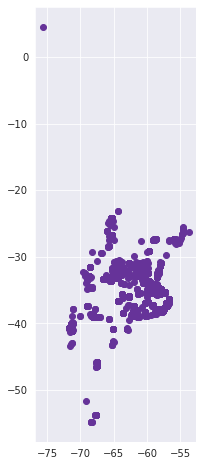

In [61]:
geo_data_raw = gpd.GeoDataFrame(data_raw, geometry = gpd.points_from_xy(data_raw.lon, data_raw.lat))
display(geo_data_raw.shape)
display(geo_data_raw.geometry.dtype)
display(geo_data_raw.plot(color='rebeccapurple', figsize=(6,8)))

Como habíamos visto en la sección anterior, estas variables registran 51.550 datos nulos, los cuales representan un 42.53 % de las observaciones y explican un 7.39 % de los datos faltantes totales. De modo que estamos pudiendo georreferenciar apenas un poco más de la mitad de los registros del dataset. Pero además, del ploteo realizado de las observaciones que sí se encuentran georreferenciadas, podemos inferir que hay inmuebles cuyos puntos no se encuentran siquiera en el pais, por lo que habrá que validar estas ubicaciones segun la localidad publicada en la web.
Esta incongruencia responde a que las variables de localización no georreferenciada se cargan manualmente mientras que las de coordenadas lo hacen de manera automática por la ubicación del dispositivo desde el que se realiza la carga, que puede no coincidir con la ubicación de la propiedad.

A fin de validar los datos georreferenciados con los que cuenta el dataset espacial creado y asignar coordenadas a las observaciones que no las tienen, se procede a la importacion y georreferenciación de dos dataset:
* departamentos de Argentina del INDEC 
* centroides de los departamentos del IGN

El primero lo utilizaremos para identificar las incongruencias en las variables de ubicación del dataset y el segundo, para asignar, en la próxima instancia del trabajo práctico, una ubicación georreferenciada a las observaciones que no cuentan con una. 

In [62]:
#importación dataset INDEC
url = '/content/drive/MyDrive/DH - DESAFIO I/departamento_indec.csv'
dpto_indec = pd.read_csv(url)

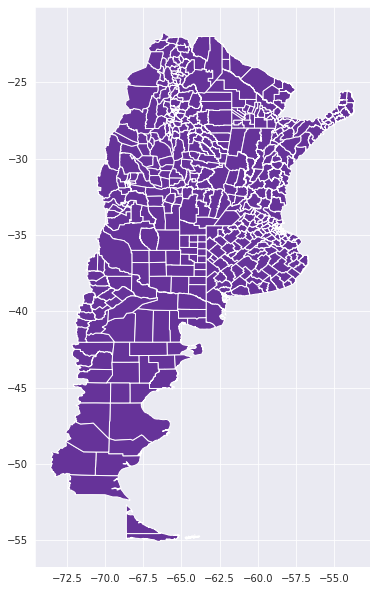

In [63]:
#creación de dataset espacial
dpto_indec["WKT"] = dpto_indec["WKT"].apply(shapely.wkt.loads) 
geo_dpto_indec = gpd.GeoDataFrame(dpto_indec, geometry='WKT')
geo_dpto_indec=geo_dpto_indec.loc[(geo_dpto_indec.departamen != 'Antártida Argentina') &
                                  (geo_dpto_indec.departamen != 'Islas del Atlántico Sur')] 
geo_dpto_indec.plot(color='rebeccapurple', figsize=(6,12))

In [64]:
#importación dataset IGN y selección de variables de interés
url = '/content/drive/MyDrive/DH - DESAFIO I/loc_centroid_IGN.csv'
centroides = pd.read_csv(url)
centroides_clean = centroides.loc[:, ('nom_pcia', 'nombre', 'lat_gd', 'long_gd')]
centroides_clean.rename({'nombre': 'place_name'}, axis=1, inplace=True)

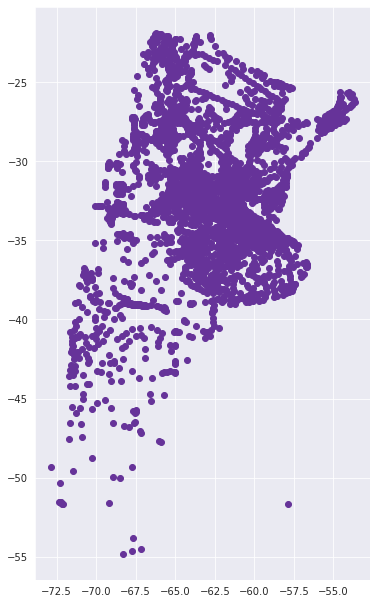

In [65]:
#creación de dataset espacial
geo_centroides = gpd.GeoDataFrame(centroides_clean, geometry = gpd.points_from_xy(centroides_clean.long_gd, centroides_clean.lat_gd))
geo_centroides.plot(color='rebeccapurple', figsize=(6,12))

* El primer cruce realizado fue entre los puntos del dataset espacial creado a partir de la base de Properati (con 69.670 de las 121.220 observaciones georreferenciadas) y el dataset espacial creado a partir de la base de departamentos del INDEC, con el objetivo de quedarnos solamente con los datos que se encuentren dentro del interior del polígono del país. Al realizar una nueva visualización, ahora sí se observan sólo aquellos inmuebles cuya georeferenciación se encuentra dentro de la Argentina (69.611 observaciones). Cabe aclarar que el hecho de que los puntos se encuentren dentro del pais no necesariamente significa que estén correctamente georreferenciados. 

cantidad de observaciones del dataset: 121220
cantidad de observaciones del dataset con coordenadas antes del cruce: 69670
cantidad de observaciones del dataset con coordenadas después del cruce: 69611


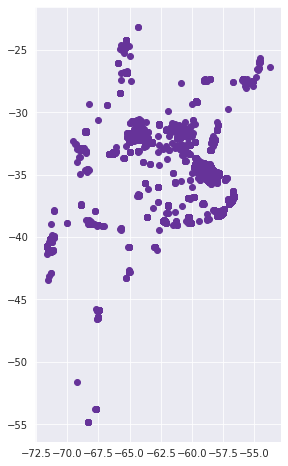

In [66]:
cruce1 = gpd.sjoin(left_df=geo_data_raw,right_df=geo_dpto_indec, how='inner')
print('cantidad de observaciones del dataset:', geo_data_raw.shape[0])
print('cantidad de observaciones del dataset con coordenadas antes del cruce:', geo_data_raw.shape[0]-data_raw['lat-lon'].isnull().sum())
print('cantidad de observaciones del dataset con coordenadas después del cruce:', cruce1.shape[0])
display(cruce1.plot(color='rebeccapurple', figsize=(5,8)))

* Se procedió entonces a realizar una segunda verificacion entre los datos de la variable provincia consignados en la columna "state_name" del dataset de Properati, y la columna "provincia" del dataset del INDEC. De esta manera, se pudo identificar que 227 de los 69.611 inmuebles georreferenciados tienen sus coordenadas en provincias distintas a las que declaran, las cuales fueron eliminadas como se muestra a continuación:

In [67]:
cruce2 = cruce1
cruce2['geometry'] = cruce1.apply(lambda x : x['geometry'] if x['state_name'] == x['provincia'] else np.nan, axis=1)
cruce2_clean = cruce2.loc[:,('properati_url','geometry')]
print('inmuebles con cooedenadas en el polígono del país:', cruce2_clean.shape[0])
print('inmuebles con cooedenadas en provincias distintas a las que se declaran:', cruce2.geometry.isnull().sum())

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


inmuebles con cooedenadas en el polígono del país: 69611
inmuebles con cooedenadas en provincias distintas a las que se declaran: 227


Finalmente, se incorporó a la base original de Properati los datos de las geometrías obtenidas por los cruces realizados. Se optó por hacer un merge con la columna "properati_url" como key ya que no tiene NaNs y es única. Ya con el dataset limpio, se revisan la cantidad de inmuebles que no poseen coordenadas, que incluyen los missing originales (51.550), las observaciones con coordenadas fuera del país (59) y aquelllas georreferenciadas en provincias que no corresponden con las declaradas (227):

In [68]:
geo_data_final = pd.merge(data_raw, cruce2_clean, on="properati_url",how='outer')
geo_data_final = geo_data_final.drop(columns='geometry_x')
geo_data_final.rename({'geometry_y': 'geometry'}, axis=1, inplace=True)
display(geo_data_final.shape)
display(geo_data_final.geometry.isnull().sum())

(121220, 28)

51836

In [69]:
print('PASANDO EN LIMPIO')
print('Cantidad de observaciones totales:', data_raw.shape[0])
print('Cantidad de observaciones sin coordenadas:', data_raw['lat-lon'].isnull().sum())
print('Cantidad de observaciones con coordenadas:', data_raw['lat-lon'].notnull().sum(), ', de las cuales')
print('   -', data_raw['lat-lon'].notnull().sum()-cruce1.shape[0], 'se encuentran fuera del polígono del país')
print('   -', cruce1.shape[0], 'se encuentran dentro del polígono del país, de las cuales')
print('      *', cruce1.geometry.isnull().sum(), 'se encuentran georreferenciadas en provincias diferentes a las declaradas')
print('      *', cruce1.shape[0]-cruce1.geometry.isnull().sum(), 'se encuentran georreferenciadas en provincias que coinciden con las declaradas')
print('Cantidad de observaciones sin coordenadas o con coordenadas fuera del polígono:', 
      data_raw['lat-lon'].isnull().sum() + data_raw['lat-lon'].notnull().sum() - cruce1.shape[0])
print('Cantidad de observaciones sin coordenadas, con coordenadas fuera del polígono o diferentes a las declaradas:',
      data_raw['lat-lon'].isnull().sum() + data_raw['lat-lon'].notnull().sum() - cruce1.shape[0] + cruce1.geometry.isnull().sum())

PASANDO EN LIMPIO
Cantidad de observaciones totales: 121220
Cantidad de observaciones sin coordenadas: 51550
Cantidad de observaciones con coordenadas: 69670 , de las cuales
   - 59 se encuentran fuera del polígono del país
   - 69611 se encuentran dentro del polígono del país, de las cuales
      * 227 se encuentran georreferenciadas en provincias diferentes a las declaradas
      * 69384 se encuentran georreferenciadas en provincias que coinciden con las declaradas
Cantidad de observaciones sin coordenadas o con coordenadas fuera del polígono: 51609
Cantidad de observaciones sin coordenadas, con coordenadas fuera del polígono o diferentes a las declaradas: 51836


En la próxima entrega del trabajo evaluaremos alternativas para imputar valores a estos campos con datos faltantes. Una posibilidad podría ser a partir de las coordenadas de los centroides de los departamentos donde se encuentran ubicadas las propiedades.

# ANÁLISIS Y CONCLUSIONES FINALES

Hasta aquí se ha llegado con el proceso de *data wrangling* para esta etapa. Como puede verse, se redujeron considerablemente los datos faltantes: 

In [70]:
missing_final= pd.DataFrame({'cantidad':data_raw.isnull().sum()})
missing_final['%_faltantes']=(missing_final.cantidad/missing_final.cantidad.sum()*100).round(2)
missing_final['%_variable']=(missing_final.cantidad/data_raw.shape[0]*100).round(2)
missing_final.loc[missing_final.cantidad>0].sort_values(by='cantidad', ascending=False)

,cantidad,%_faltantes,%_variable
floor,96820,16.26,79.87
expenses,68734,11.54,56.70
lat,51550,8.66,42.53
lon,51550,8.66,42.53
lat-lon,51550,8.66,42.53
price_usd_per_m2,51329,8.62,42.34
surface_total_in_m2,38021,6.38,31.37
price_per_m2,33562,5.63,27.69
rooms,29184,4.90,24.08
price_aprox_local_currency,20410,3.43,16.84


En los siguientes gráficos y tablas presentamos algunas correlaciones entre las variables exploradas. Éstas muestran cómo la superficie, la cantidad de ambientes, el tipo de propiedad y la localización, podrían afectar en el precio de los inmuebles, lo cual abordaremos con mayor profundidad en las modelizaciones a realizar en la próxima etapa. 

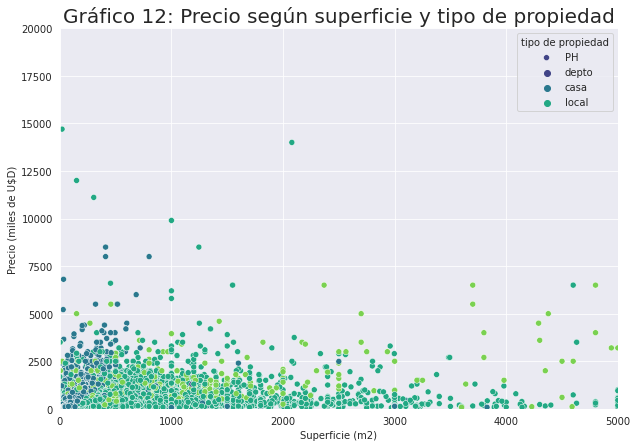

In [71]:
#ScatterPlot 
#con ajuste de intervalo de ejes
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
sns.scatterplot(data=data_raw, x='surface_total_in_m2', y=data_raw['price_aprox_usd']/1000, hue='property_type', palette='viridis')
ax.set_xlim(0, 5000)    
ax.set_ylim(0, 20000)

plt.title('Gráfico 12: Precio según superficie y tipo de propiedad', size=20);
plt.xlabel('Superficie (m2)'); 
plt.ylabel('Precio (miles de U$D)');
plt.legend(['PH', 'depto', 'casa', 'local'], title='tipo de propiedad'); 
plt.show()

<Figure size 432x288 with 0 Axes>

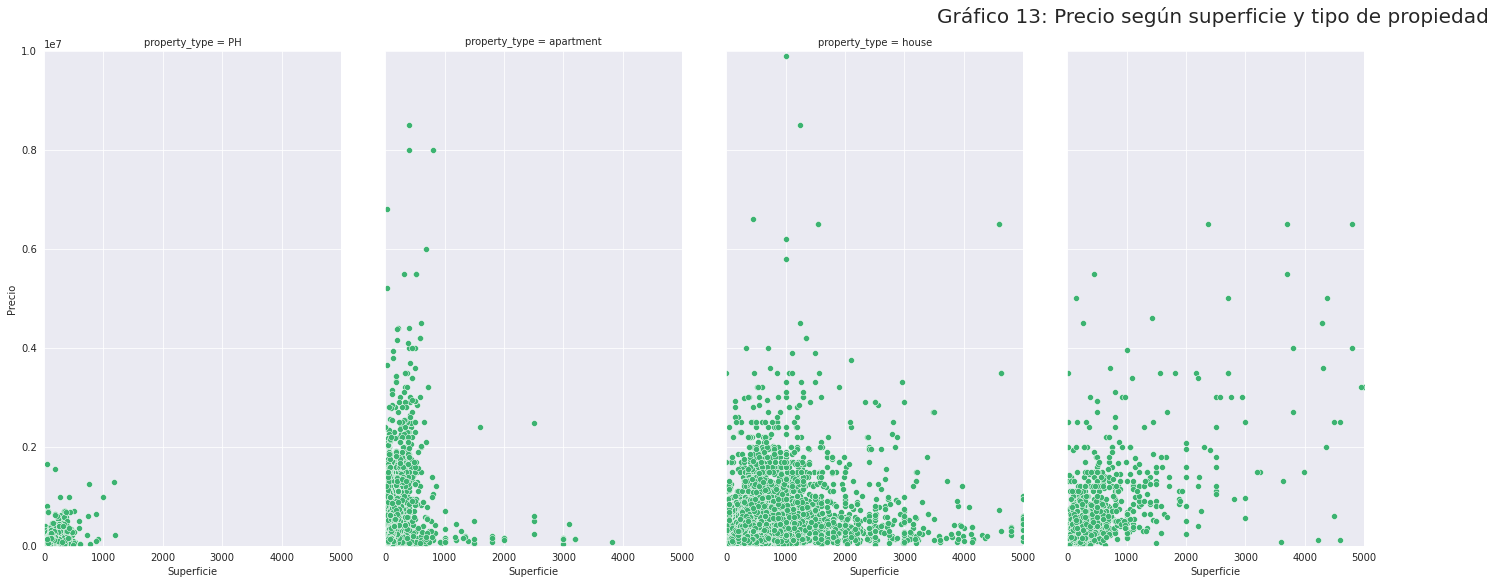

In [72]:
sns.set_style('darkgrid')
fig = plt.figure()


g = sns.FacetGrid(data=data_raw, col='property_type', xlim=(0,5000), ylim=(0,10000000))
g.map(sns.scatterplot,'surface_total_in_m2', 'price_aprox_usd', color='mediumseagreen')
g.fig.set_size_inches(20,10)
g.set_axis_labels("Superficie", "Precio")
plt.title('Gráfico 13: Precio según superficie y tipo de propiedad \n', size=20);
plt.show()

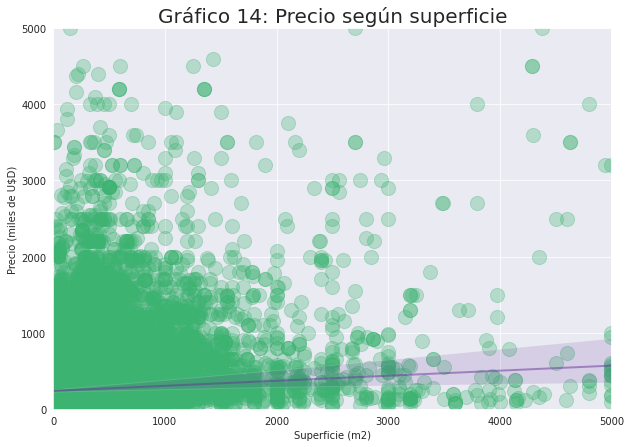

In [73]:
#ScatterPlot 
#con regresión
#con ajuste de intervalo de ejes
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
sns.regplot(x=data_raw['surface_total_in_m2'], y=data_raw['price_aprox_usd']/1000, 
            line_kws={"color":'rebeccapurple',"alpha":0.5,"lw":2},
            scatter_kws={"color":"mediumseagreen","alpha":0.3,"s":200})
ax.set_xlim(0, 5000)    
ax.set_ylim(0, 5000)

plt.title('Gráfico 14: Precio según superficie', size=20);
plt.xlabel('Superficie (m2)'); 
plt.ylabel('Precio (miles de U$D)');
plt.show()

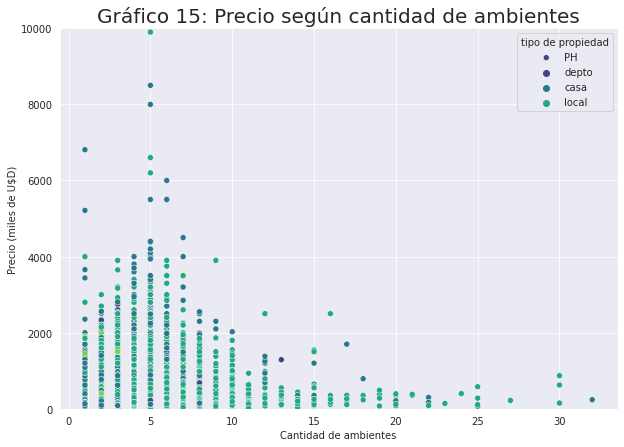

In [74]:
#ScatterPlot 
#con ajuste de intervalo de ejes
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
sns.scatterplot(data=data_raw, x='rooms', y=data_raw['price_aprox_usd']/1000, hue='property_type', palette='viridis')

ax.set_ylim(0, 10000)

plt.title('Gráfico 15: Precio según cantidad de ambientes', size=20);
plt.xlabel('Cantidad de ambientes'); 
plt.ylabel('Precio (miles de U$D)');
plt.legend(['PH', 'depto', 'casa', 'local'], title='tipo de propiedad'); 
plt.show()

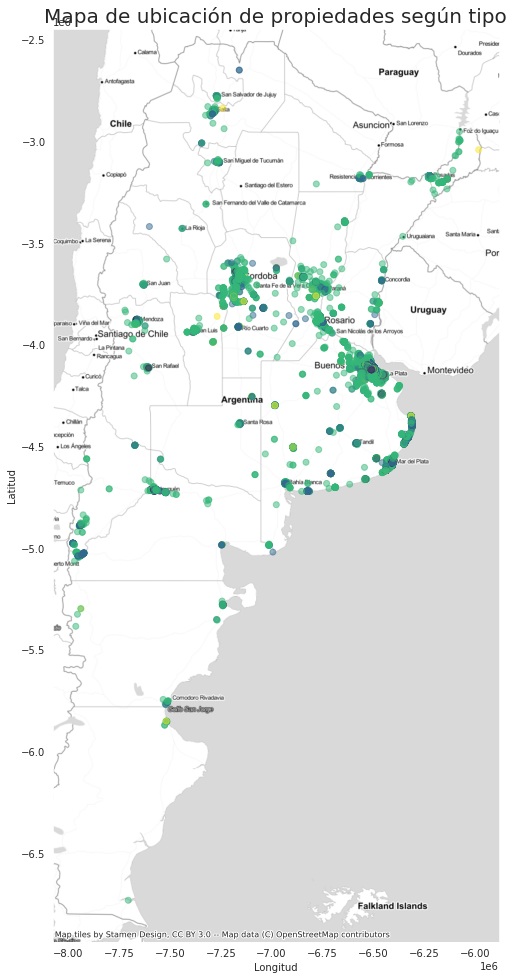

In [75]:
fig, ax = plt.subplots(figsize=(8,20))
plt.grid()

cruce2.crs = "EPSG:4326"                       
geo_data_3857 = cruce2.to_crs(epsg=3857)       
geo_data_3857.plot(ax=ax,
                   legend = False,
                   column='property_type',
                   cmap='viridis',
                   alpha= 0.5)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.title('Mapa de ubicación de propiedades según tipo', size=20);
plt.ylabel('Latitud');
plt.xlabel('Longitud'); 
plt.show()


In [76]:
tabla_precios = data_raw.pivot_table(index='region', columns='property_type', aggfunc={'price_aprox_usd':np.mean, 'surface_total_in_m2':np.mean})
tabla_precios.loc[('Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur', 
                   'Buenos Aires Costa Atlántica', 'Buenos Aires Interior', 'Córdoba', 'Santa Fe'),:].round()

price_aprox_usd                                \
property_type                             PH apartment     house     store   
region                                                                       
Capital Federal                     189433.0  245347.0  501268.0  514980.0   
Bs.As. G.B.A. Zona Norte            136045.0  201113.0  426327.0  550361.0   
Bs.As. G.B.A. Zona Oeste            110475.0  114466.0  218530.0  404753.0   
Bs.As. G.B.A. Zona Sur              110617.0  124159.0  250338.0  392463.0   
Buenos Aires Costa Atlántica         89489.0  117381.0  213872.0  261157.0   
Buenos Aires Interior               102303.0  148960.0  209488.0  245354.0   
Córdoba                             351598.0  139767.0  292671.0  289199.0   
Santa Fe                             81173.0  127895.0  187405.0  251078.0   

                             surface_total_in_m2                           
property_type                                 PH apartment   house  store  
region                                                                     
Capital Federal                            129.0      88.0   456.0  306.0  
Bs.As. G.B.A. Zona Norte                   113.0      90.0   496.0  738.0  
Bs.As. G.B.A. Zona Oeste                   114.0      66.0   391.0  631.0  
Bs.As. G.B.A. Zona Sur                     117.0      79.0   347.0  862.0  
Buenos Aires Costa Atlántica               101.0      85.0   501.0  407.0  
Buenos Aires Interior                      148.0      88.0  1332.0  427.0  
Córdoba                                     88.0     224.0   806.0  636.0  
Santa Fe                                    85.0     109.0   372.0  203.0